# Data Fundamentals (H)
John H. Williamson -- Session 2018/2019

----
<font color="red"> Read the submission instructions at the bottom of this notebook **carefully** before submitting </font> 

**This submission must be your own work; you will have to make a Declaration of Originality on submission.**

Note that marks shown when tests pass are **provisional** and could change after grading.

In [1]:
NAME = "Stuart Reilly" ## fill these in 
STUDENT_ID = "2258082"  ## e.g. 2222222

---

## Lab 4: Assessed
# Vector spaces and linear transforms

### Notes
It is recommended to keep the lecture notes open while doing this lab exercise. Read through this lab *carefully* and work through the tasks.

This lab is marked out of 50.

### References
If you are stuck, the following resources are very helpful:

* [NumPy cheatsheet](https://github.com/juliangaal/python-cheat-sheet/blob/master/NumPy/NumPy.md)
* [NumPy API reference](https://docs.scipy.org/doc/numpy-1.13.0/reference/)
* [NumPy user guide](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.html)




## Purpose of this lab
This lab should help you:
* understand how data can be represented as points in vector space
* understand the effect of different vector norms
* apply the inner product to compute the angle between vectors
* apply linear transforms to vectors

In [2]:
# Standard imports
# Make sure you run this cell!
# NumPy
import numpy as np  
import binascii

# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

# custom utils
from jhwutils.checkarr import array_hash, check_hash
import jhwutils.image_audio as ia
import jhwutils.tick as tick

def case_crc(s):
    return binascii.crc32(bytes(s.lower(), 'ascii'))

print("Everything imported OK")

Everything imported OK


In [3]:
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)


## Guidance
You will need to understand the following functions well to complete this lab:
You will need to understand the following functions well to complete this lab:
* [`np.argmin()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argmin.html) [Unit 1]
* [`np.argsort()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argsort.html) [Unit 1]
* [`np.linalg.norm()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html) [Unit 4]
* [`np.linalg.svd()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html) [Unit 5]
* [`np.linalg.eig()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.eig.html) [Unit 5]
* [`np.cov()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.cov.html) [Unit 4]

## Whisky: Representing and comparing vectors

Whisky distillation is a major industry in Scotland. 

<img src="imgs/stills.jpg"> <br><br>*[[Image](https://flickr.com/photos/sashafatcat/518104633 "stills") by [sashafatcat](https://flickr.com/people/sashafatcat) shared [CC BY](https://creativecommons.org/licenses/by/2.0/)]*

The dataset in `data/whisky.csv` is data from a number of whisky distilleries. For each distillery, there are a set of subjective judgements about the flavour characteristics of their production. The data comes from [this Strathclyde University research project](https://www.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html).

Each distillery has been judged on twelve flavour indicators (like "smokiness" or "sweetness"), and they have been assigned values from 0-3 indicating the strength of that category, judged by an expert whisky drinker. These can be seen as 12D vectors, one vector per distillery. **Every distillery is represented as a point in twelve dimensional vector space.**

We also have a 2D array of the geographical locations of each distillery. The code below loads the data.

## Loading the data

In [4]:
## It is not necessary to understand this code to complete
# the exercise. We don't cover pandas in DF(H)
import pandas as pd
whisky_df = pd.read_csv("data/whiskies.txt")
whisky_df = whisky_df.sort_values(by='Distillery')
# extract the column and row names
distilleries= np.array(whisky_df["Distillery"])

columns = {name.lower():index for index,name in enumerate(whisky_df.columns[2:-3])}

# split apart the data frame and form numpy arrays
locations = np.array(whisky_df.iloc[:,-2:])
whisky = np.array(whisky_df.iloc[:,2:-3])

# fix wine column
columns['wine'] = columns['winey']
del columns['winey']
# force tie breaks 
np.random.seed(2018)
whisky = whisky + np.random.normal(0,0.1,whisky.shape)

## Viewing the data

We can see this whole dataset as a heatmap:

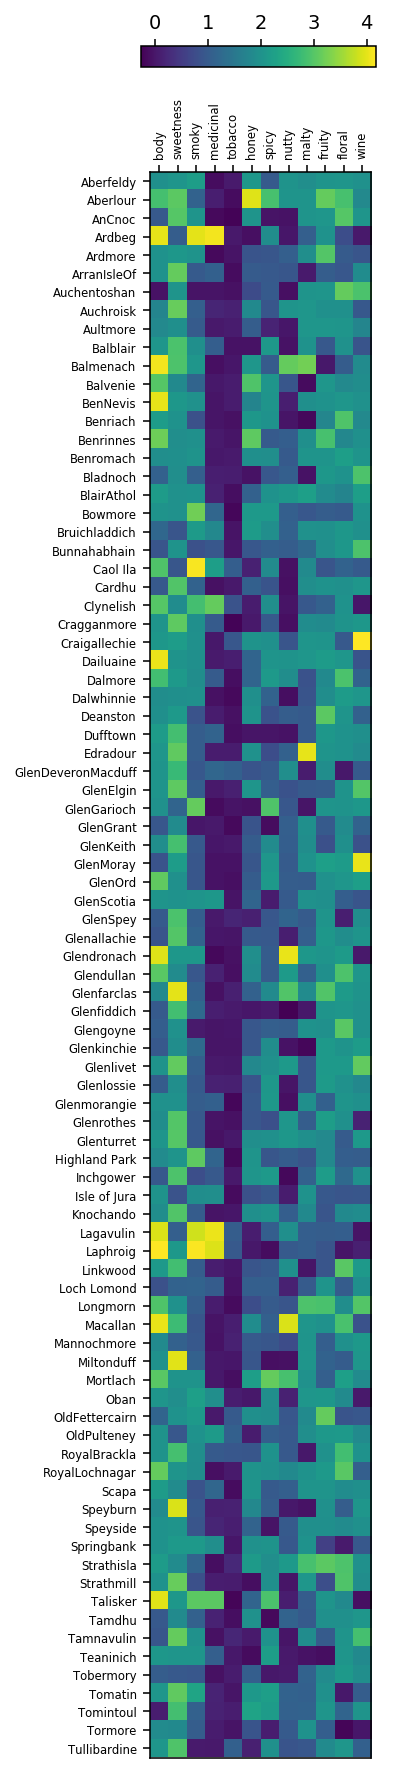

In [5]:
# show a plot of the whisky data
fig = plt.figure(figsize=(6,15))
ax = fig.add_subplot(1,1,1)

# image plot
img = ax.imshow(whisky)
ax.set_yticks(np.arange(len(distilleries)))
ax.set_yticklabels(distilleries, rotation="horizontal", fontsize=6)

# put the x axis at the top
ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation="vertical", fontsize=6)

# some horrific colorbar hackery to put in the right place
# don't worry about this bit!
cbaxes = fig.add_axes([0.37, 0.93, 0.28, 0.01])  
fig.colorbar(img, orientation='horizontal',  cax=cbaxes, ticks=np.arange(5))
cbaxes.xaxis.tick_top()

### Available data
You now have these variables:

* `whisky` an  86x12 array of taste judgements, one row for each of the 86 distilleries. Each whisky has a rating 0-3 for each of the 12 flavour categories.
* `distilleries` is a list of 86 distillery names
* `columns` is a mapping of feature names to column indices.
* `locations` is an 86x2 matrix of positions of each distillery in [OS grid reference format](https://www.gridreferencefinder.com/) in the same order as `whisky`

For example:

In [6]:
print(whisky[distilleries.searchsorted('Glenfiddich'), columns['smoky']])

1.2551637969677651


will tell you how "smoky" Glenfiddich was rated.

In [7]:
print(distilleries[8])

Aultmore


will tell you the 9th distillery in the dataset is `Aultmore`.

In [8]:
print(locations[distilleries.searchsorted('Glengoyne')])

[252810 682750]


will tell you where to find the Glengoyne distillery in UK OS grid units (you can almost see it out of the BO720 window if you look northwest). 

## A: Norms, interpolation and statistics
We will see some simple things we can do with this dataset. 


We can compute distances in **flavour space** between distilleries.

For example, we can compute the distance between the `Glenlivet` distillery and every other distillery *in terms of flavour, not physical distance*. The result will be a 1D vector of 86 distances. 

Remember: distance of $\vec{x}$ and $\vec{y}$ is the norm of their difference: $\|\vec{x}-\vec{y}\|$

We can compute this for several different norms (e.g. $L_1, L_2$, and $L_\infty$)

We need to compute the norm by telling `np.linalg.norm` to compute the lengths of vectors over columns (`axis=1`), as we have an $N\times D$ matrix: $N$ rows of observations (distilleries), each with $D$ measurements (flavour ratings).

In [9]:
# Get the flavout vector for Glenlivet
glenlivet = whisky[distilleries.searchsorted('Glenlivet')]
print(glenlivet)

[2.01755609 3.10969454 1.07845611 0.02881886 0.01150817 1.80465997
 1.958898   2.12901747 0.91876381 2.13262264 2.14421457 3.11448683]


In [10]:
## Compute distances
# must use axis=1 to get the right result
# otherwise a matrix norm will be used!
glenlivet_2 = np.linalg.norm(whisky - glenlivet, 2, axis=1)
glenlivet_1 = np.linalg.norm(whisky - glenlivet, 1, axis=1)
glenlivet_inf = np.linalg.norm(whisky - glenlivet, np.inf, axis=1)

### Visualising these distances
We can visualise these distances. This lets us see which distilleries produce whisky most similar to Glenlivet and which of them are most dissimilar. Note that we can use `argsort` to order a list of distances. Below, we plot a faceted graph, one facet for each norm, showing each distillery's flavour distance to `Glenlivet` as a rank bar plot (see Unit 3). The labels are a bit small, but the graphs are a useful summary of the distances in this abstract 12 dimensional space.

/home/stuart/.local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


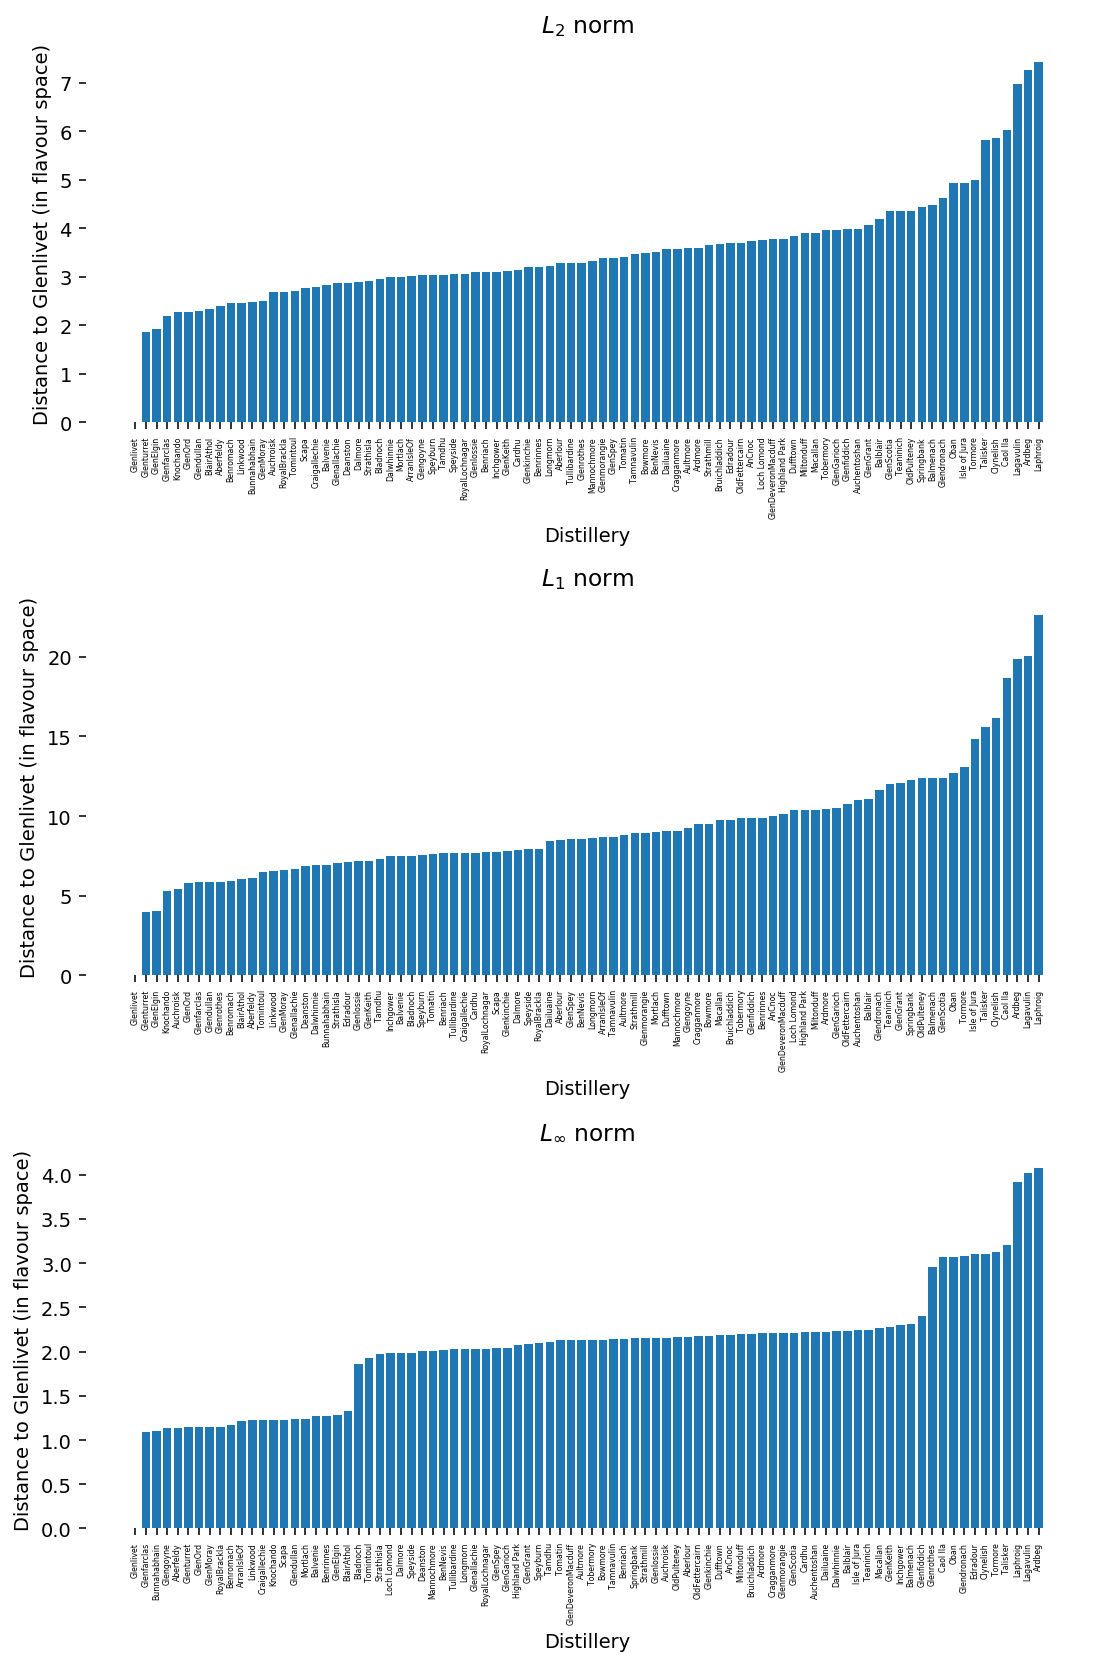

In [11]:
fig = plt.figure(figsize=(8,12))

# you can use this utility function to
# help you get the xticklabels in order
def list_in_order(alist, order):
    """Given a list 'alist' and a list of indices 'order'
    returns the list in the order given by the indices"""
    return [alist[i] for i in order]
    

ax = fig.add_subplot(3,1,1)

def rank_plot(distances):
    # find the ordering of the distances
    order = np.argsort(distances)
    # bar plot them
    ax.bar(np.arange(len(distances)), distances[order])           
    ax.set_xlabel("Distillery")
    ax.set_ylabel("Distance to Glenlivet (in flavour space)")
    ax.set_xticks(np.arange(86))    
    ax.set_frame_on(False)
    # make sure the same order is used for the labels!
    ax.set_xticklabels(list_in_order(distilleries, order),
                       rotation="vertical", fontsize=4)

# make the plots
ax = fig.add_subplot(3,1,1)
ax.set_title("$L_2$ norm")
rank_plot(glenlivet_2)
ax = fig.add_subplot(3,1,2)
ax.set_title("$L_1$ norm")
rank_plot(glenlivet_1)
ax = fig.add_subplot(3,1,3)
ax.set_title("$L_\infty$ norm")
rank_plot(glenlivet_inf)

# removes ugly overlapping
plt.tight_layout()


## Tasks

**Task A.1** 

Compute the $L_2$ norm of each distillery's flavour vector from the flavour vector corresponding to the distillery `Auchentoshan`, and store it in `auchentoshan_2`

In [14]:
# YOUR CODE HERE
auchentoshan = whisky[distilleries.searchsorted('Auchentoshan')]
auchentoshan_2 = np.linalg.norm(whisky - auchentoshan, 2, axis=1)

In [15]:
with tick.marks(4):        
    assert(check_hash(auchentoshan_2, ((86,), 16258.378367770209)))
    

**Task A.2** 
Which distillery is furthest from Auchentoshan's flavour profile in the $L_2$ norm? Store the distillery name in the variable in `unlike_auchentoshan`. Note: compute this -- do not look hardcode it.


In [22]:
# YOUR CODE HERE
auchentoshan = whisky[distilleries.searchsorted('Auchentoshan')]
auchentoshan_2 = np.linalg.norm(whisky - auchentoshan, 2, axis=1)

unlike_auchentoshan = distilleries[np.argsort(auchentoshan_2)[-1]]

In [23]:
with tick.marks(4):        
    assert(case_crc(unlike_auchentoshan)==2291391646)
    print("The distillery most unlike Auchentoshan (L2 norm speaking) is {distillery}.".
          format(distillery=unlike_auchentoshan))


The distillery most unlike Auchentoshan (L2 norm speaking) is Laphroig.


**Note** from now on, use the L2 norm if you need to compute any norms.


### Vector arithmetic
A client says to you:
    
>    I'd like something a bit like Balvenie. But a bit more "lively", the way Cragganmore is more "lively" than Springbank.

Which whisky should you recommend? 
**Task A.3**


We can work this out:
* What does more "lively" mean? We don't have a "lively" column.
    * But we do have a reference point: Springbank->Cragganmore is somehow "lively"
    * This "direction" between these flavour vectors is *also* a vector
* How do we combine Balvenie's flavour profile with "lively"? We can compose vectors by addition.
* How do we find a distillery that represents this profile? We can compute lengths of vectors using a norm.

Compute:
* `lively` A vector representing what "lively" is
* `hypothetical_flavour` A vector representing a hypothetical flavour that would be a more lively Balvenie
* `recommendation` the name of a specific distillery that we might recommend, as a string.

**Note: this question is not subjective, nor does it require any trial-and-error or knowledge about whisky. Answer it directly using vector arithmetic.**



In [37]:
# YOUR CODE HERE
craggen = whisky[distilleries.searchsorted("Cragganmore")]
spring = whisky[distilleries.searchsorted("Springbank")]
lively = craggen - spring
hypothetical_flavour = whisky[distilleries.searchsorted("Balvenie")] + lively
norm_2 = np.linalg.norm(whisky - hypothetical_flavour, 2, axis=1)
recommendation = distilleries[np.argmin(norm_2)]

In [26]:
with tick.marks(2):
    assert(check_hash(lively, ((12,), 17.40202214153395)))
    

In [28]:
with tick.marks(2):
    assert(check_hash(hypothetical_flavour,((12,), 136.04856251122936)))

In [38]:
print("I would recommend {distillery} as more 'lively' version of Balevenie.".format(distillery=
                                                                   recommendation))

with tick.marks(1):
    assert(case_crc(recommendation)==2634813176)



I would recommend Benriach as more 'lively' version of Balevenie.


**Task A.4** Find the distillery that best represents (L2 norm) a flavour profile halfway between `Lagavulin` and `Bowmore`. Store the name in a variable `halfway_whisky`.

In [87]:
# YOUR CODE HERE
laga = whisky[distilleries.searchsorted("Lagavulin")]
bow = whisky[distilleries.searchsorted("Bowmore")]
laga_2 = np.linalg.norm(whisky - laga, 2, axis=1)
bow_2 = np.linalg.norm(whisky - bow, 2, axis=1)

halfway_whisky = distilleries[np.argmin(abs(laga_2-bow_2))]

In [86]:
with tick.marks(4):
    assert(case_crc(halfway_whisky)==2804822615)
print("The whisky that best represents a 50:50 mix of Lagavulin and Bowmore is {distillery}".format(distillery=halfway_whisky))

The whisky that best represents a 50:50 mix of Lagavulin and Bowmore is Caol Ila


## Region flavours

We could say that the "representative" element of a collection of vectors was the one closest to the geometric centroid. This is given by the **mean vector** of a data set.

**Task A.5** Compute the mean vector of all of the flavour vectors. Use it to find the names of two distilleries:
* `most_representative` The distillery with the **most** representative flavour profile
* `least_representative` The distillery with the **least** representative flavour profile

In [ ]:
# YOUR CODE HERE


In [ ]:
with tick.marks(4):
    assert(case_crc(most_representative)==125187962)
    assert(case_crc(least_representative)==2291391646)
    
print("The most representative whisky distillery is {most}, and the most unusual is {least}".format(most=most_representative,
                                                                                           least=least_representative))


### A map
The code below will show a map of Scotland, with the distilleries in their correct positions. Different geographic regions have different characteristic flavour profiles.

One very distinctive region is **Speyside**. This is a region bounded roughly by the box

    263000,860000 -> 343000,785000
    
in the same OS grid units used in the `locations` array. This is highlighted on the map below.


In [ ]:
from whisky_map import draw_map, map_box

# draw each distillery label at the locations given.
ax = draw_map(locations, distilleries)

# show the Speyside region
# draw a box in OS grid units
map_box(ax, 263000, 785000, 343000,860000 )

**Task A.6**
* Find all distilleries in Speyside and use this to answer these questions:
* `speyside_flavour`: Compute the most typical whisky flavour profile for Speyside. (i.e. a 12 element vector).
* `most_typical_speyside`: The specific name of the distillery from Speyside that is most typical of that region;
* `least_typical_speyside`: The specific name of the distillery from Speyside that is least typical of that region;
* `most_like_speyside`: The specific name of the distillery from **outside** Speyside that is most similar to a typical Speyside distillery.


**Note:** do not do any of this by hand. Write code.
Hint: Boolean arrays.

In [ ]:
# YOUR CODE HERE

In [ ]:
with tick.marks(2):
    assert(check_hash(speyside_flavour, ((12,), 121.21683682933062)))

In [ ]:
print("The most typical whisky of Speyside is {most}.".format(most=most_typical_speyside))
print("The least typical Speyside whisky of the style is {least}.".format(least=least_typical_speyside))
print("The non-Speyside whisky most like a Speyside whisky is {nonspeyside}.".
      format(nonspeyside=most_like_speyside))        

In [ ]:
with tick.marks(2):
    assert(case_crc(most_typical_speyside)==125187962)

In [ ]:
with tick.marks(2):    
    assert(case_crc(least_typical_speyside)==3190173608)

In [ ]:
with tick.marks(3):    
    assert(case_crc(most_like_speyside)==3551803812)

# B: Eigendecompositions and whitening

## Focusing data
<img src="imgs/drop.jpg" width="40%"> <br><br>*[[Image](https://flickr.com/photos/predi/236902022 "just a droplet, but upside down") by [Predi](https://flickr.com/people/predi) shared [CC BY-ND](https://creativecommons.org/licenses/by-nd/2.0/)]*

This part will use  matrix decompositions to form abstract "lenses" that let us see data from different perspectives. This will let us pull out hidden structure and translate among representations.

## Demeaning
The dataset that we have is unnormalised. It is a set of ratings, 0-4, and many of the attributes rated are very correlated (e.g. `smoky` and `medicinal`). Many of the ratings are also on quite different scales, with `tobacco` being much less likely to be rated 4 that `floral`.

It is easier to work with normalised data. 

**Task B.1**
Compute:
* `mean_vector` the average flavour profile (you should have this from part A already)
* `demeaned_whisky` that has the mean flavour vector removed. 



In [ ]:
# YOUR CODE HERE

In [ ]:
## Show the mean vector as an image strip
## Remember: this represents a point in space
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = ax.imshow(mean_vector[None,:], cmap='viridis', vmin=0, vmax=3)
ax.set_xticklabels(columns)
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks([])
ax.set_title("Mean vector of flavour profile")
fig.colorbar(img, orientation='horizontal')

with tick.marks(2):
    assert(check_hash(demeaned_whisky, ((86, 12), -13044.960552493923)))

* **Task B.2**
Compute the **covariance matrix** of the *demeaned* data. Call this **whisky_cov**. The code below will show you this matrix as an image. **Note**: this should be a 12x12 matrix!

This tells us how different columns of the dataset are correlated (co-vary) with each other.

We can see several interesting things:
* having `body` is negatively correlated with the `wine` flavour
* being `smoky` is negatively correlated with having `sweetness`
* `nutty` is positively correlated with `body`

Although the raters have provided 12 different categories, it seems these are not fully independent of each other.


In [ ]:
# YOUR CODE HERE

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = ax.imshow(whisky_cov, cmap='seismic', vmin=-1.5, vmax=1.5)
ax.set_xticks(np.arange(12))
ax.set_yticks(np.arange(12))
ax.set_yticklabels(columns)
ax.set_xticklabels(columns, rotation='vertical')
ax.set_title("Covariance matrix")
fig.colorbar(img)


with tick.marks(2):
    assert(check_hash(whisky_cov, ((12, 12), 611.8479842916136)))
    

## Eigendecomposition of the covariance matrix

From this covariance matrix, we can start to see the "most important" directions in which the whisky dataset tends to vary. This will be some combination of the various flavour categories. We can analyse this by looking at the covariance matrix in more detail. Recall that the covariance matrix represents an ellipse that "covers" the dataset. The primary axes of this ellipsoidal shape can be found directly from the **eigenvectors** of the covariance matrix. This describes the directions in which the dataset varies. It will let us see truly independent directions of variation.

These are the **principal components** of the dataset. We can compute these  from the covariance matrix by taking the eigendecomposition. Each eigenvector of the covariance matrix is a **principal component** and its importance is given by the inverse square root of the absolute value of its corresponding eigenvalue.

**Task B.3**
* Compute all 12 of the eigenvectors of the covariance matrix, in order, *smallest* corresponding (absolute) eigenvalue first. Store this in `whisky_pc`. 
* Store the corresponding principal component importance in `whisky_pc_len`. The importance (or length) of a principal component can be computed from the corresponding eigenvalue $\lambda$ as $\frac{1}{\sqrt{\lambda}}$.



In [ ]:
# YOUR CODE HERE

In [ ]:
## We can show the principal components as an image
## Each row is a princpal component, and shows a vector
## which represents the direction of variation. The first
## vector represents the largest component, the second
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# space out the principal components, and scale them by the
# length of the components
img = ax.imshow(np.concatenate([(whisky_pc.T*whisky_pc_len).T, 
                                np.zeros_like(whisky_pc)], axis=1).reshape(24,-1), 
                cmap='seismic',         
                vmin=-4, vmax=4)

ax.set_xticks(np.arange(12))
ax.set_yticks(np.arange(0,24,2))
ax.set_yticklabels(["PC{i}".format(i=i) for i in np.arange(12)])
ax.set_xticklabels(columns, rotation='vertical')
ax.set_title("Principal components")
ax.set_frame_on(False)
fig.colorbar(img)

## Show the principal component lengths of this dataset
## This shows how much of the variation in the dataset
## is "explained" by the variation along the corresponding direction.
## In this case, we should see that the first component is quite
## large, and looking at the principal components plot above, this
## appears to indicate that there is a spectrum of whiskies
## from "body" types to "malty" types (PC1)
## and from "smoky" types to floral/fruity types (PC2)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.bar(np.arange(len(whisky_pc_len)), whisky_pc_len)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(["PC{i}".format(i=i) for i in np.arange(12)])
ax.set_frame_on(False)
ax.set_title("Component importances")


In [ ]:
with tick.marks(4):
    assert(check_hash(whisky_pc, ((12, 12), 176.61972724966714)))
    assert(check_hash(whisky_pc_len, ((12,), 106.36639712233577)))

## Projecting onto the principal components

This is interesting, but quite hard to interpret. One very useful technique is to project data onto a small number of principal components, to visualise the data. This forms a simplified version of the data, where the use of principal components means we can map the directions in the data which are most important to our visual axes. For example, we might map the first two principal components to a 2D $x,y$ plot.

This is a key technique in exploratory data analysis: **principal component analysis**. All it involves is using the principal components to find a simplified mapping onto a lower-dimensional space.

We can compute a projection of a dataset onto an arbitrary set of vectors by forming a matrix product:
$$P = XV,$$

Where $P$ is an $N\times k$ matrix that is the result of the projection, $X$ is the $N \times D$ original data set and $V$ is an $D \times k$ matrix, each of whose *columns* is a vector that we want to project onto.

**Task B.4**
Use this information to project the distillery data onto the first two principal components, and store the result in `whisky_projected_2d`. If you do this correctly, the plot below should show a 2D mapping of whisky flavours, where more distant distilleries in the map represent more distinct flavour styles.




In [ ]:
# YOUR CODE HERE

In [ ]:
## Show the whisky distilleries laid out
## on the two first principal components
## Colouring the points according to the level of smokiness 
## (just to see that similar whiskies are indeed clustered together)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_frame_on(False)
ax.set_xlabel("Principal component 1")
ax.set_ylabel("Principal component 2")
ax.set_title("Principal component analysis of whisky distillery flavour profiles")
ax.scatter(whisky_projected_2d[:,0], whisky_projected_2d[:,1], c=whisky[:,columns['smoky']], s=10)
for i,name in enumerate(distilleries):
    ax.text(whisky_projected_2d[i,0], whisky_projected_2d[i,1], name, fontdict={'size':6})

In [ ]:
with tick.marks(4):
    assert(check_hash(whisky_projected_2d, ((86, 2), -5645.1773024318845)))


We can normalise this data further. Whiten the dataset to that is zero mean and has unit covariance. This transforms our dataset so that it is centered on the origin (demeaning) and "spherical" (whitenening with covariance matrix). This is particularly useful if we are going to try and map from data in one vector space to another; having the data in standard scaling, with no offset and no correlation among dimensions makes the data easier to work with.

**Task B.5**
Use the SVD to compute the inverse matrix square root of the matrix $\text{whisky_cov}^{-1/2}$. Multiply the demeaned whisky matrix with this to produce `whitened_whisky`. This represents the data with the mean removed, and all correlations eliminated.



In [ ]:
# YOUR CODE HERE

In [ ]:
# This plot of the covariance matrix should now be perfectly diagonal
plt.imshow(np.cov(whitened_whisky.T), vmin=0, vmax=2, cmap='viridis')

with tick.marks(4):
    assert(check_hash(whitened_whisky, ((86, 12), -13904.23411235108)))

### Visualising in normalised space
Now that we have the data normalised, we could also define a more sensible way to compare vectors in a high-dimensional space. The $L_2$ norm has significant problems in very high-dimensional spaces. A more sensible way to compare vectors is to look at the *angle* between them.

**Task B.6**
Define a function `cosine(a,b)` that computes the cosine of the angle between two vectors $a$ and $b$ of the same length (i.e. returns $\cos(\theta)$, a value between -1 and 1).


In [ ]:
def cosine(a,b):
    # YOUR CODE HERE

In [ ]:
angles = np.array([cosine(whitened_whisky[i,:], whitened_whisky[j,:]) for i in range(len(whisky)) for j in range(len(whisky))])


with tick.marks(4):
    assert(check_hash(angles, ((7396,), 25457.146694199713)))
    

## A 3D visualisation
We can use this to show a different layout of whiskies; this time in terms of relative angles to two reference distillieries, in the whitened space. This has the advantage that all distances are normalised to the range [-1,1], and we have a good spread of points in the space. The plot below shows the angle with respect to 3 distilleries, as a 3D plot.

(you can compare with the plot using the unwhitened data to see the effect that normalisation has had, if you wish).

This is also an example of why visualising data in 3D is usually a bad idea.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import matplotlib.pyplot as plt
%matplotlib notebook

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1, projection='3d')

## Modify these to plot the flavours on different axes
ref_a = 'Glengoyne'
ref_b = 'Laphroig'
ref_c = 'Glenlivet'

## get the respective flavour vectors
reference_a = whitened_whisky[distilleries.searchsorted(ref_a)]
reference_b = whitened_whisky[distilleries.searchsorted(ref_b)]
reference_c = whitened_whisky[distilleries.searchsorted(ref_c)]

for name, flavour in zip(distilleries, whitened_whisky):
    ## compute angles to the references
    angle_a = cosine(reference_a, flavour)
    angle_b = cosine(reference_b, flavour)
    angle_c = cosine(reference_c, flavour)

    ax.scatter(angle_a, angle_b, angle_c, color='c', s=5)
    ax.text(angle_a, angle_b, angle_c, name, fontdict={"size":10}, alpha=0.5)
    
## fix up the plot
ax.set_xlabel("Angle with respect to {ref_a}".format(ref_a=ref_a))
ax.set_ylabel("Angle with respect to {ref_b}".format(ref_b=ref_b))
ax.set_zlabel("Angle with respect to {ref_c}".format(ref_c=ref_c))
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_zlim(-1.1, 1.1)
ax.set_title("Normalised flavour angles between whisky distilleries")


-----

# Submission instructions

### Checking your work
## Mark summary
You should check the marks you've got before submitting. To do this, 
* Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and matriculation number at the top.
* SAVE THE NOTEBOOK, 
* Go to `Cell/Restart and Run All` in the menu.
* Check the output of the cell here.

Note that this is an estimated mark, and if you don't do the above procedure *carefully* you may get nonsense estimates.


In [ ]:
tick.summarise_marks()

### Formatting the submission
* **WARNING**: If you do not submit the correct file, you will not get any marks.
* Submit this file **only** on Moodle. It will be named `lab_<xxx>.ipynb`.


## Penalties (only for assessed labs)
<font color="red">
    
**Malformatted submissions**
</font>
These assignments are processed with an automatic tool; failure to follow instructions *precisely* will lead to you automatically losing two bands in grade regardless of whether the work is correct (not to mention a long delay in getting your work back). **If you submit a file without your work in it, it will be marked and you will get 0 marks.**

<font color="red">**Late submission**</font>
Be aware that there is a two band penalty for every *day* of late submission, starting the moment of the deadline.

<font color="red">
    
**Plagiarism**
</font> Any form of plagiarism will be subject to the Plagiarism Policy. The penalties are severe.